In [64]:
import pandas as pd
import numpy as np
import xgboost as xgb
import re
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import joblib
from joblib import Parallel, delayed

In [65]:
def extract_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

def load_csv(file):
    df = pd.read_csv(file)
    df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
    df['SibSp'] = pd.to_numeric(df['SibSp'], errors='coerce')
    df['Fare'] = pd.to_numeric(df['Fare'], errors='coerce')
    df['Pclass'] = pd.to_numeric(df['Pclass'], errors='coerce')
    df['SexNum']= df['Sex'].apply({'male':1, 'female':0}.get)
    df['EmbarkedNum']= df['Embarked'].apply({'C':0, 'Q':1, 'S':2}.get)
    df['CabinPresent'] = df['Cabin'].notna()
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = 1
    df['IsAlone'].loc[df['FamilySize'] > 1] = 0
    df['Title'] = df['Name'].apply(extract_title)
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    #df['FarePerPerson'] = df['Fare'] / df['FamilySize'] #Fare is per ticket, ticket includes multiple people?
    df['Title'] = LabelEncoder().fit_transform(df['Title'])
    df["Deck"] = df["Cabin"].str[:1]
    df["Deck"] = df["Deck"].replace(np.nan,"N/A")
    df.loc[df["Deck"]=='T',"Deck"] = 'N/A'
    replaces = {'B51 B53 B55': 'B55', 'B52 B54 B56': 'B56', 'B57 B59 B63 B66': 'B66', 'B58 B60': 'B60', 
                'B82 B84': 'B84', 'B96 B98': 'B98', 'C22 C26': 'C26', 'C23 C25 C27': 'C27', 'C55 C57': 'C57',
                'C62 C64': 'C64', 'D10 D12': 'D12', 'E39 E41': 'E41', 'F E46': 'E46', 'F E57': 'E57',
                'F E69': 'E69', 'F G63': 'G63', 'F G73': 'G73', 'F': None, 'D': None, ' ': None, 'T': None, np.nan: None}
    df["Cabin"] = df["Cabin"].replace(replaces)
    df["Cabin"] = df.fillna(np.nan)["Cabin"].str[1:].astype(float)
    for i in set(df["Deck"].values):
        v = df[df["Deck"]==i]["Cabin"]//2
        df.loc[df["Deck"]==i, "Cabin"]= v
        df.loc[(df["Deck"]==i) & (df["Cabin"]==0),"Cabin"] = np.median(v)
    df.loc[df["Cabin"].isna(),"Cabin"]=-1
    df["Cabin"] = df["Cabin"].astype(int)
    df["Side"] = df["Cabin"]
    df.loc[df["Side"]!=0,"Side"] = (df["Cabin"][df["Cabin"]!=0]%2-0.5)*2
    df["Side"] = df["Side"].fillna(0)
    df["Fare"] = df["Fare"].rank(method='max')
    df.loc[df["Embarked"].isna(),"Embarked"] = "S"

    return df

train = load_csv("data/train.csv")
train['Survived'] = pd.to_numeric(train['Survived'], errors='coerce')
test = load_csv("data/test.csv")

train.head()

C:\Users\elian\AppData\Local\Temp\ipykernel_33608\2835533684.py:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['IsAlone'].loc[df['FamilySize'] > 1] = 0
C:\Users\elian\AppData\Local\Temp\ipykernel_33608\2835533684.py:19: SettingWithCopy

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SexNum,EmbarkedNum,CabinPresent,FamilySize,IsAlone,Title,Deck,Side
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,83.0,-1,S,1,2.0,False,2,0,2,N/A,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,789.0,42,C,0,0.0,True,2,0,3,C,-1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,241.0,-1,S,0,2.0,False,1,1,1,N/A,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,750.0,61,S,0,2.0,True,2,0,3,C,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,285.0,-1,S,1,2.0,False,1,1,2,N/A,1


C:\Users\elian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Best parameters: {'subsample': 1.0, 'reg_lambda': 0, 'reg_alpha': 0, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 0.6}


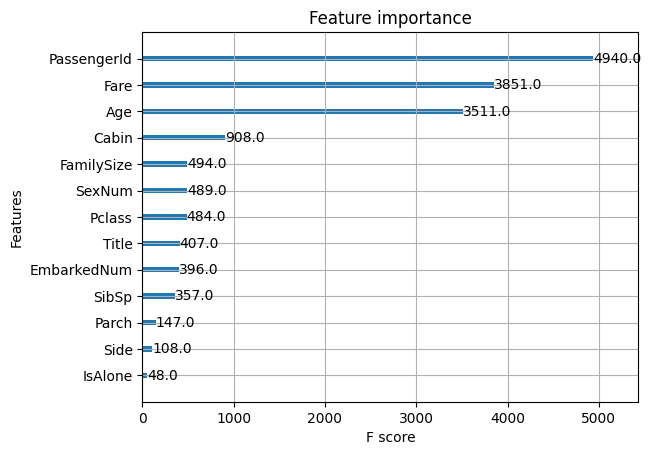

In [68]:
y = train["Survived"]
features = ['Pclass', 'SexNum', 'Age', 'SibSp', 'Parch', 'Fare', 'EmbarkedNum', 'PassengerId', 'Cabin', 'FamilySize', 'IsAlone', 'Title', 'Side']
X = train[features]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

parameters = {
    'max_depth': range(3, 10, 2),
    'min_child_weight': range(1, 6, 2),
    'gamma': [0, 0.1, 0.2, 0.5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000],
    'reg_alpha': [0, 1e-5, 1e-2, 0.1, 1],
    'reg_lambda': [0, 1e-5, 1e-2, 0.1, 1, 100]
}


model = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.05, n_jobs=16, device="cuda", use_label_encoder=False, objective='binary:logistic', tree_method="hist")
model.fit(X, y, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)], 
             verbose=False)
xgb.plot_importance(model)

gsearch = RandomizedSearchCV(estimator=model, param_distributions=parameters, cv=3, scoring='accuracy')
gsearch.fit(X_train, y_train)
print("Best parameters:", gsearch.best_params_)
best_model = gsearch.best_estimator_

In [69]:
test_predictions = model.predict(test[features])

submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": test_predictions
})

submission['Survived'] = submission['Survived'].astype(int)

submission.to_csv('output/xgboost.csv', index=False)
